In [3]:
%load_ext autoreload
%autoreload 2
import keras
import numpy as np
from encoder import create_encoder
from data_processing import processer
from RepresentationLearner import RepresentationLearner
from compute import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()


In [5]:
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

In [6]:
target_size = 32
representation_dims = 512
projection_units = 128
num_clusters = 28
kn = 5
tune_encoder_during_clustering = False

In [7]:
x_data = x_data.astype('float32')
processer.layers[-1].adapt(x_data)
x_data

array([[[[ 59.,  62.,  63.],
         [ 43.,  46.,  45.],
         [ 50.,  48.,  43.],
         ...,
         [158., 132., 108.],
         [152., 125., 102.],
         [148., 124., 103.]],

        [[ 16.,  20.,  20.],
         [  0.,   0.,   0.],
         [ 18.,   8.,   0.],
         ...,
         [123.,  88.,  55.],
         [119.,  83.,  50.],
         [122.,  87.,  57.]],

        [[ 25.,  24.,  21.],
         [ 16.,   7.,   0.],
         [ 49.,  27.,   8.],
         ...,
         [118.,  84.,  50.],
         [120.,  84.,  50.],
         [109.,  73.,  42.]],

        ...,

        [[208., 170.,  96.],
         [201., 153.,  34.],
         [198., 161.,  26.],
         ...,
         [160., 133.,  70.],
         [ 56.,  31.,   7.],
         [ 53.,  34.,  20.]],

        [[180., 139.,  96.],
         [173., 123.,  42.],
         [186., 144.,  30.],
         ...,
         [184., 148.,  94.],
         [ 97.,  62.,  34.],
         [ 83.,  53.,  34.]],

        [[177., 144., 116.],
       

In [8]:
encoder = create_encoder(representation_dims)
representation_leaner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)

lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)



In [9]:
representation_leaner.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=lr_scheduler, weight_decay=0.0001
    ), jit_compile=False
)


In [10]:
history = representation_leaner.fit(
    x=x_data,
    batch_size=512,
    epochs=50
)

Epoch 1/50


I0000 00:00:1747230799.992045   76004 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-14 14:53:24.749280: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-14 14:53:24.749329: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-14 14:53:24.749338: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

118/118 ━━━━━━━━━━━━━━━━━━━━ 62s 284ms/step - loss: 63.7630
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 259ms/step - loss: 11.2723
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 264ms/step - loss: 10.8126
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 265ms/step - loss: 10.5318
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 262ms/step - loss: 10.4492
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 263ms/step - loss: 10.3552
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 267ms/step - loss: 10.2742
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 267ms/step - loss: 10.1931
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 29s 249ms/step - loss: 10.0870
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 264ms/step - loss: 9.9259
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 32s 267ms/step - loss: 9.8441
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 265ms/step - loss: 9.7299
Epoch 13/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 259ms/step - loss: 9.5640
Epoch 14/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 262ms/step - loss: 9.4775
Epoch 15/50
118/1

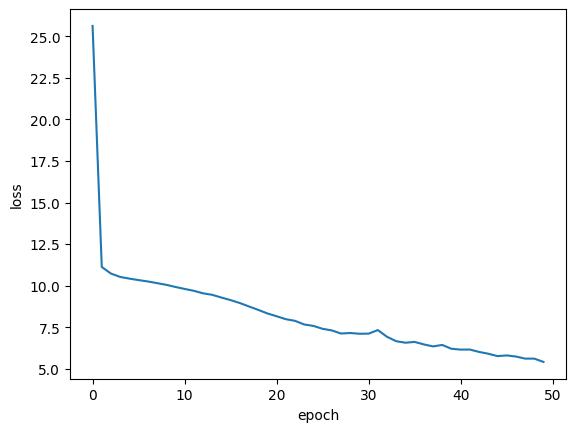

In [14]:
from graph import loss_graph
loss_graph(history.history['loss'])

In [15]:
knns = compute_knn(representation_leaner.encoder.predict(x_data), 512, kn)

I0000 00:00:1747232887.884776   76002 service.cc:152] XLA service 0x7f8109ef8750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747232887.884989   76002 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-05-14 15:28:07.998348: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-14 15:28:09.702679: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1483', 204 bytes spill stores, 204 bytes spill loads

2025-05-14 15:28:09.790291: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1483_0', 396 bytes spill stores, 2300 bytes spill loads

2025-05-14 15:28:09.997881: 

  37/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

I0000 00:00:1747232892.542538   76002 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step


100%|██████████| 117/117 [00:04<00:00, 26.46it/s]


In [16]:
knns

array([[12768,  1342,  5540, 35610, 50098],
       [12768,  1342,  5540, 35610, 50098],
       [12768,  1342,  5540, 35610, 50098],
       ...,
       [12768,  1342,  5540, 35610, 50098],
       [12768,  1342,  5540, 35610, 50098],
       [12768,  1342,  5540, 35610, 50098]], dtype=int32)

In [17]:
projection = representation_leaner.predict(x_data)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 47s 23ms/step


In [18]:
projection

array([[0.00471219, 0.11077215, 0.00383967, ..., 0.        , 0.16696805,
        0.202366  ],
       [0.13624236, 0.        , 0.20490414, ..., 0.22074315, 0.08117681,
        0.12472501],
       [0.11546542, 0.        , 0.10736348, ..., 0.32894152, 0.11995228,
        0.6649975 ],
       ...,
       [0.41645515, 0.25667405, 0.39748523, ..., 0.20540309, 0.21898505,
        0.12237239],
       [0.2222518 , 0.17551467, 0.537086  , ..., 0.18272586, 0.1510675 ,
        0.        ],
       [0.18090947, 0.0419575 , 0.        , ..., 0.20058464, 0.24804923,
        0.21352082]], dtype=float32)